# Data 

In [1]:
!pip install wget
!pip install twython
import wget
import sys

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/reviews.zip")
#!unzip reviews.zip

In [3]:
data = pandas.read_csv('reviews.csv')
data.columns=['filePath','hotelName','reviewColumn','ratingScore','groundTruth']
data.head()

,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,data/ca/2645488/1231007/209555602.html,Osler House,"""I've been home in upstate New York for a week...",5,positive
1,data/ca/2645488/1231007/226421625.html,Osler House,"""My husband and I stayed in the Edmund Osler r...",5,positive
2,data/ca/2645488/1231007/137689823.html,Osler House,"""I stayed at Osler House while working out in ...",5,positive
3,data/ca/2645488/1231007/144657969.html,Osler House,"""We visit our children in Hamilton and usually...",5,positive
4,data/ca/2645488/1231007/428521379.html,Osler House,"""A fine place to rest,\nIf a solid night's sle...",5,positive


###Q1: Sentiment Analysis and Aggregation

###(a)

In [0]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [0]:
reviews = data['reviewColumn'].values

In [6]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 4494/4494 [00:05<00:00, 782.78it/s]


In [7]:
reviewDF.head()

,reviewCol,vader
0,"""I've been home in upstate New York for a week...",0.9906
1,"""My husband and I stayed in the Edmund Osler r...",0.9834
2,"""I stayed at Osler House while working out in ...",0.9806
3,"""We visit our children in Hamilton and usually...",0.9921
4,"""A fine place to rest,\nIf a solid night's sle...",0.9081


In [8]:
reviewDF['vader'].value_counts(ascending=True)

 0.7713     1
 0.8038     1
 0.9629     1
-0.9340     1
-0.5694     1
           ..
 0.7003    10
 0.9839    11
 0.9371    11
 0.9705    14
 0.0000    16
Name: vader, Length: 2095, dtype: int64

In [9]:
reviewDF['vader'].describe()

count    4494.000000
mean        0.686527
std         0.531939
min        -0.994200
25%         0.737425
50%         0.934550
75%         0.973800
max         0.999600
Name: vader, dtype: float64

In [0]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
topk, finaldf = dataFrameTransformation(data, reviewDF, k=500)

In [12]:
finaldf.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,hotel,room,stay,staff,breakfast,clean,great,would,rooms,good,nice,stayed,one,hamilton,night,comfortable,friendly,well,area,desk,bed,place,time,front,nthe,get,location,parking,could,also,service,back,like,restaurant,check,...,areas,lady,chose,queen,canada,window,homewood,past,daughter,variety,motel,job,bill,deal,facilities,worst,equipped,waiting,per,facility,children,average,safe,jacuzzi,start,bacon,traffic,dated,walked,certainly,soon,concert,received,carpet,appreciated,wish,star,greeted,member,items
0,Osler House,5,positive,"""I've been home in upstate New York for a week...",0.9906,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Osler House,5,positive,"""My husband and I stayed in the Edmund Osler r...",0.9834,0,1,1,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Osler House,5,positive,"""I stayed at Osler House while working out in ...",0.9806,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Osler House,5,positive,"""We visit our children in Hamilton and usually...",0.9921,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Osler House,5,positive,"""A fine place to rest,\nIf a solid night's sle...",0.9081,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
avg_vader_sent = finaldf.groupby('hotelName')['vader'].mean()
avg_vader_sent = pandas.DataFrame(avg_vader_sent)
avg_vader_sent

,vader
hotelName,
Admiral Inn Hamilton,0.690158
Airport Inn,0.131070
Best Western Plus Burlington Inn &amp; Suites,0.728237
Best Western Premier C Hotel By Carmen&#39;s,0.871549
Breakfast at Tifferet&#39;s,0.307800
Canadas Best Value Inn-Burlington/Hamilton,0.531797
Comfort Inn,0.854436
Comfort Inn Hamilton,0.512235
Convenient &amp; Comfortable Manor,-0.859100


In [14]:
avg_rating_sent = finaldf.groupby('hotelName')['ratingScore'].mean()
avg_rating_sent = pandas.DataFrame(avg_rating_sent)
avg_rating_sent

,ratingScore
hotelName,
Admiral Inn Hamilton,3.744186
Airport Inn,2.123077
Best Western Plus Burlington Inn &amp; Suites,4.017544
Best Western Premier C Hotel By Carmen&#39;s,4.713415
Breakfast at Tifferet&#39;s,3.500000
Canadas Best Value Inn-Burlington/Hamilton,3.766667
Comfort Inn,4.372727
Comfort Inn Hamilton,3.146667
Convenient &amp; Comfortable Manor,1.000000


###(b)

In [15]:
hotelNames = finaldf['hotelName'].unique()
hotelNames

array(['Osler House', 'The Homestead 1867 Bed &amp; Breakfast',
       'Olympia Village RV Park &amp; Campground',
       'Canadas Best Value Inn-Burlington/Hamilton', 'Crestwood Motel',
       'Best Western Plus Burlington Inn &amp; Suites',
       'Holiday Inn Burlington Hotel &amp; Conference Centre',
       'Waterfront Hotel Downtown Burlington', 'Royal Motel',
       'Knights Inn Burlington', 'Comfort Inn', 'The Barracks Inn',
       'Serenity Ranch Bed and Breakfast', 'Ridgemoor B&amp;B',
       'Pleasant Stay Motel', 'Homestead House Bed &amp; Breakfast',
       'Super 8 by Wyndham Mt Hope Hamilton Intl Arpt on', 'Hamilton Inn',
       'Downtown Hamilton Guest House', 'Sandman Hotel Hamilton',
       'Hamilton Plaza Hotel and Conference Center',
       'Days Inn by Wyndham Hamilton',
       'Four Points by Sheraton Hamilton - Stoney Creek',
       'Residence &amp; Conference Centre - Hamilton',
       'Best Western Premier C Hotel By Carmen&#39;s',
       'Convenient &amp; Comfo

In [0]:
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

1. Average Ground Truth Sentiment

In [0]:
hotelRatingDfGt = getHotelRank(finaldf)

In [18]:
hotelRatingDfGt.head()

,hotelName,avgRatingScore
32,Log Inn,5.000000
1,The Homestead 1867 Bed &amp; Breakfast,5.000000
12,Serenity Ranch Bed and Breakfast,4.976471
0,Osler House,4.938776
11,The Barracks Inn,4.921569


In [19]:
hotelRatingDfGt.tail()

,hotelName,avgRatingScore
37,Airport Inn,2.123077
17,Hamilton Inn,2.068966
18,Downtown Hamilton Guest House,2.000000
14,Pleasant Stay Motel,2.000000
25,Convenient &amp; Comfortable Manor,1.000000


2. Average Vader Compound Sentiment Score

In [0]:
hotelRatingDfVd = getHotelRank(finaldf, measure='vader')

In [21]:
hotelRatingDfVd.head()

,hotelName,avgRatingScore
32,Log Inn,0.997100
13,Ridgemoor B&amp;B,0.971866
1,The Homestead 1867 Bed &amp; Breakfast,0.960514
12,Serenity Ranch Bed and Breakfast,0.949677
11,The Barracks Inn,0.947759


In [22]:
hotelRatingDfVd.tail()

,hotelName,avgRatingScore
8,Royal Motel,0.110160
4,Crestwood Motel,0.003380
17,Hamilton Inn,-0.000972
18,Downtown Hamilton Guest House,-0.069300
25,Convenient &amp; Comfortable Manor,-0.859100


**Ans 1(b):**

Comparing the top-5 of both the measures, it was found that 4 out of 5 were ranked top in both the cases. Similarly, comparing the bottom-5, it was found that 3 out of 5 were ranked bottom in both the cases.

This shows that among 10 observations, vader sentiment is able to recall 70% of the observations correctly. Precision is compratively less as the ranking of each hotel is different in both the cases.

###Q2: Frequency Analysis

###(a)

In [23]:
termfreq = finaldf[['reviewCol','groundTruth','vader']]
termfreq

,reviewCol,groundTruth,vader
0,"""I've been home in upstate New York for a week...",positive,0.9906
1,"""My husband and I stayed in the Edmund Osler r...",positive,0.9834
2,"""I stayed at Osler House while working out in ...",positive,0.9806
3,"""We visit our children in Hamilton and usually...",positive,0.9921
4,"""A fine place to rest,\nIf a solid night's sle...",positive,0.9081
...,...,...,...
4489,"""It was nice, they made me oatmeal when they s...",positive,0.4215
4490,"""These reviews are almost like bizarro world, ...",negative,0.9961
4491,"""I would STRONGLY recommend this place to stay...",positive,0.9787
4492,"""On a recent visit to Hamilton to visit my bro...",positive,0.9943


In [0]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

**1. Positive Reviews**


In [25]:
topkGroundPos = getTopK(df=termfreq, k=50, label_value='positive')
topkGroundPos

[('great', 1805),
 ('clean', 1621),
 ('breakfast', 1613),
 ('nice', 1242),
 ('would', 1209),
 ('good', 1168),
 ('stayed', 1127),
 ('hamilton', 1125),
 ('comfortable', 1064),
 ('friendly', 1008),
 ('well', 879),
 ('one', 868),
 ('area', 841),
 ('bed', 730),
 ('place', 698),
 ('night', 690),
 ('location', 658),
 ('time', 652),
 ('nthe', 634),
 ('also', 612),
 ('parking', 598),
 ('service', 592),
 ('restaurant', 588),
 ('helpful', 585),
 ('desk', 576),
 ('front', 551),
 ('pool', 549),
 ('recommend', 533),
 ('food', 518),
 ('back', 511),
 ('excellent', 502),
 ('best', 486),
 ('really', 484),
 ('could', 478),
 ('like', 466),
 ('get', 460),
 ('everything', 451),
 ('definitely', 442),
 ('made', 430),
 ('check', 416),
 ('home', 410),
 ('beautiful', 410),
 ('free', 401),
 ('close', 395),
 ('beds', 391),
 ('two', 390),
 ('large', 385),
 ('hot', 383),
 ('day', 381),
 ('shane', 380)]

**2. Negative Reviews**

In [26]:
topkGroundNeg = getTopK(df=termfreq, k=50, label_value='negative')
topkGroundNeg

[('would', 739),
 ('night', 606),
 ('one', 595),
 ('breakfast', 582),
 ('desk', 499),
 ('good', 484),
 ('get', 474),
 ('front', 461),
 ('clean', 457),
 ('stayed', 451),
 ('could', 417),
 ('time', 360),
 ('nice', 358),
 ('bed', 340),
 ('check', 334),
 ('floor', 329),
 ('place', 323),
 ('nthe', 322),
 ('like', 320),
 ('parking', 315),
 ('back', 293),
 ('told', 286),
 ('hamilton', 281),
 ('even', 275),
 ('door', 274),
 ('location', 271),
 ('bathroom', 261),
 ('great', 254),
 ('people', 252),
 ('also', 252),
 ('area', 248),
 ('got', 236),
 ('never', 236),
 ('well', 232),
 ('friendly', 230),
 ('two', 228),
 ('service', 228),
 ('next', 225),
 ('went', 219),
 ('day', 216),
 ('booked', 213),
 ('around', 212),
 ('said', 205),
 ('morning', 202),
 ('asked', 200),
 ('first', 198),
 ('really', 197),
 ('shower', 192),
 ('comfortable', 182),
 ('water', 181)]

**Ans 2(a):**

It is seen that there are many words that are occuring in both positive and negative reviews like 'good', 'nice', 'breakfast' etc. From this it is evident that sentiment of one word cannot be used to justify the sentiment of the whole review and has a very little effect on it. Since, the sentiment analysis only takes into consideration positive and negative reviews, it is highly possible that neutral reviews or sentiment may be wrongly classified.

###(b)

In [0]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
#stop = set(stopwords.words('english'))
#Add possible Stop Words for Hotel Reviews
stopwords.add('hotel')
stopwords.add('room')
stopwords.add('rooms')
stopwords.add('stay')
stopwords.add('staff')

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [0]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [0]:
tagger = PerceptronTagger()

In [0]:
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [0]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(data, reviewDF, k=50)

In [34]:
topk_phrase

[('front desk', 540),
 ('hot tub', 127),
 ('seren ranch', 107),
 ('park lot', 97),
 ('downtown hamilton', 85),
 ('great locat', 81),
 ('hamilton area', 78),
 ('great place', 73),
 ('continent breakfast', 73),
 ('comfort bed', 66),
 ('complimentari breakfast', 66),
 ('first time', 62),
 ('next morn', 62),
 ('next time', 60),
 ('homewood suit', 58),
 ('next day', 53),
 ('niagara fall', 50),
 ('free breakfast', 50),
 ('sheraton hamilton', 49),
 ('hamilton airport', 47),
 ('pool area', 46),
 ('second floor', 46),
 ('custom servic', 44),
 ('comfort inn', 43),
 ('day inn', 43),
 ('osler hous', 41),
 ('good valu', 41),
 ('easi access', 41),
 ('good locat', 41),
 ('credit card', 38),
 ('queen bed', 38),
 ('bedroom suit', 38),
 ('king bed', 37),
 ('best western', 37),
 ('park garag', 37),
 ('great experi', 36),
 ('hot water', 36),
 ('breakfast area', 35),
 ('good thing', 34),
 ('first floor', 34),
 ('first night', 33),
 ('nice place', 33),
 ('great view', 33),
 ('earli check', 32),
 ('coffe mak

In [0]:
def getTopKPhrase(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):

    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)
    return topk

**1. Positive Reviews - Noun Phrase**

In [36]:
topkPhrasePos = getTopKPhrase(df=termfreq, k=50, label_value='positive')
topkPhrasePos

[('front desk', 285),
 ('seren ranch', 107),
 ('hot tub', 99),
 ('hamilton area', 72),
 ('downtown hamilton', 71),
 ('great place', 70),
 ('great locat', 63),
 ('comfort bed', 63),
 ('park lot', 50),
 ('homewood suit', 50),
 ('first time', 49),
 ('next time', 48),
 ('complimentari breakfast', 46),
 ('osler hous', 41),
 ('niagara fall', 39),
 ('free breakfast', 39),
 ('continent breakfast', 39),
 ('easi access', 38),
 ('pool area', 35),
 ('sheraton hamilton', 35),
 ('bedroom suit', 34),
 ('great experi', 32),
 ('best western', 32),
 ('barrack inn', 32),
 ('hamilton airport', 32),
 ('king bed', 30),
 ('good valu', 30),
 ('next morn', 30),
 ('nice place', 28),
 ('queen bed', 27),
 ('second floor', 27),
 ('great view', 27),
 ('next day', 26),
 ('custom servic', 26),
 ('comfort inn', 26),
 ('great valu', 25),
 ('main floor', 25),
 ('admir inn', 25),
 ('visitor inn', 25),
 ('great servic', 24),
 ('breakfast area', 24),
 ('full kitchen', 24),
 ('good locat', 23),
 ('coffe maker', 23),
 ('hami

**2. Negative Reviews - Noun Phrase**

In [37]:
topkPhraseNeg = getTopKPhrase(df=termfreq, k=50, label_value='negative')
topkPhraseNeg

[('front desk', 255),
 ('park lot', 47),
 ('continent breakfast', 34),
 ('next morn', 32),
 ('credit card', 30),
 ('hot tub', 28),
 ('bed bug', 27),
 ('next day', 27),
 ('hot water', 23),
 ('day inn', 22),
 ('complimentari breakfast', 20),
 ('first night', 19),
 ('second floor', 19),
 ('custom servic', 18),
 ('good locat', 18),
 ('great locat', 18),
 ('first floor', 17),
 ('comfort inn', 17),
 ('howard johnson', 17),
 ('air condition', 15),
 ('earli check', 15),
 ('desk clerk', 15),
 ('good thing', 15),
 ('hamilton airport', 15),
 ('park garag', 15),
 ('ice machin', 14),
 ('holiday inn', 14),
 ('crown plaza', 14),
 ('mani hotel', 14),
 ('downtown hamilton', 14),
 ('sheraton hamilton', 14),
 ('first time', 13),
 ('water pressur', 12),
 ('fire alarm', 12),
 ('busi trip', 12),
 ('next time', 12),
 ('second night', 12),
 ('front desk clerk', 11),
 ('bathroom floor', 11),
 ('free breakfast', 11),
 ('niagara fall', 11),
 ('queen bed', 11),
 ('pool area', 11),
 ('good valu', 11),
 ('breakfast

**Ans 2(b):**

Top noun phrases for both the sentiments were comparatively a little more informative than single words. Even though there were phrases common to both the sentiments, they have a much higher impact on the sentiment of the sentence.

###Q3: Mutual Information

###(a)

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf[label_column], finaldf[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
miScoredf = getMI(topk, finaldf)

In [40]:
miScoredf.head(50)

,Word,MI Score
269,dirty,0.029620
6,great,0.027432
98,told,0.026366
93,shane,0.019988
475,worst,0.017146
15,comfortable,0.016967
443,rude,0.015605
50,excellent,0.015390
97,wonderful,0.015031
76,beautiful,0.014815


**Ans 3(a):**

Mutual information considers both the positive and negative sentiments. Negative terms had higher MI compared to the positive i.e a sign of presence of the negative terms in negative reviews as well as its absence in positive reviews. It was interesting to see words like 'dirty', 'great', 'comfortable' etc. had a higher MI even though they belonged to different sentiments. As we have more number of posiitve reviews than the negative, it is expected to have words (positive) to have higher MI scores.

There is absense of any locale-specific terms which could be due to the fact that words like those would be present in both the negative and positive reviews.

###(b)

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore_phrase = []
    for noun in topk:
        miScore_phrase.append([noun[0]]+[metrics.mutual_info_score(finaldf_phrase[label_column], finaldf_phrase[noun[0]])])
    miScore_phrasedf = pandas.DataFrame(miScore_phrase).sort_values(1,ascending=0)
    miScore_phrasedf.columns = ['Phrase','MI Score']
    return miScore_phrasedf

In [0]:
miScore_phrasedf = getMI(topk_phrase, finaldf_phrase)

In [43]:
miScore_phrasedf.head(50)

,Phrase,MI Score
2,seren ranch,6.818487e-03
0,front desk,4.843126e-03
48,bed bug,4.299777e-03
29,credit card,3.962484e-03
7,great place,3.249897e-03
9,comfort bed,2.848890e-03
6,hamilton area,2.378398e-03
45,barrack inn,2.051380e-03
25,osler hous,2.051380e-03
12,next morn,1.463962e-03


**Ans 3(b):**

MI scores for noun phrases are expected to be lower than the MI scores of words, as the occurences of the same phrases in either of the reviews is less when compared to occurences of the words. Similar to the words, we also observe more positive noun phrases having higher MI scores.

The phrases such as 'front desk', 'comfort bed' etc with high MI does not tell whether it was used in a postive or negative context. This is due to the fact that MI is calculated over all the possible combinations of ground truth as well as the presense/absence of a phrase

###Q4: Pointwise Mutual Information

###(a)

In [0]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px+0.00001*py+0.00001))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [0]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px+0.0001*py+0.0001))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [47]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf)

100%|██████████| 500/500 [00:13<00:00, 36.12it/s]


In [48]:
#Sorted top pmi words for positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
93,shane,0.340218
391,shelby,0.340218
254,alan,0.340218
194,serenity,0.340218
188,ranch,0.340218
340,hosts,0.332249
243,delicious,0.323410
418,host,0.320799
193,highly,0.308324
214,loved,0.293967


In [49]:
#Sorted top pmi words for negative reviews
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
269,dirty,1.151523
475,worst,1.148150
443,rude,1.096303
396,walls,1.031617
371,poor,0.983635
406,toilet,0.969024
493,carpet,0.963501
454,cleaned,0.959356
487,dated,0.952109
98,told,0.927822


**Ans 4(a):** 

Pointwise mutual information (PMI)  is a correlation measure for two events, x and y; mutual information measures the pointwise mutual information over all possible events: that is, MI is the expectation (average) of PMI over all possible outcomes.

It is feasible to check if the token/word is used positively or negatively in the reviews. The presence of words like 'dirty', 'rude', 'worst' indicate that the place is not hygenic and not suitable to visit thereby leading to a negative experience.

There wasn't any conclusive evidence of locale-specific tokens but words like 'ranch', 'serene' indicate that people were happy with places that were quite and had a scenic view which is what led to a positive review.

###(b)

In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllPhraseCal(df, label_column='groundTruth', topk=topk_phrase):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for phrase in tqdm(topk):
        pmilist.append([phrase[0]]+[pmiCal(df,phrase[0])])
        pmiposlist.append([phrase[0]]+[pmiIndivCal(df,phrase[0],'positive',label_column)])
        pmineglist.append([phrase[0]]+[pmiIndivCal(df,phrase[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['Phrase','pmi']
    pmineglist.columns = ['Phrase','pmi']
    pmidf.columns = ['Phrase','pmi']
    return pmiposlist, pmineglist, pmidf

In [51]:
pmiposlist_phrase, pmineglist_phrase, pmidf_phrase = pmiForAllPhraseCal(finaldf_phrase)

100%|██████████| 50/50 [00:00<00:00, 50.94it/s]


In [52]:
pmiposlist_phrase.sort_values('pmi',ascending=0).head(50)

,Phrase,pmi
2,seren ranch,0.340218
25,osler hous,0.340218
45,barrack inn,0.340218
7,great place,0.297045
9,comfort bed,0.292965
31,bedroom suit,0.283059
27,easi access,0.262256
6,hamilton area,0.259092
33,best western,0.215054
35,great experi,0.211006


In [53]:
pmineglist_phrase.sort_values('pmi',ascending=0).head(50)

,Phrase,pmi
48,bed bug,1.115627
29,credit card,1.005050
36,hot water,0.709378
40,first night,0.691392
24,day inn,0.604381
15,next day,0.569006
12,next morn,0.566574
39,first floor,0.550313
8,continent breakfast,0.463302
3,park lot,0.455003


**Ans 4(b):**

Words like 'serene ranch', 'downtown hamilton', 'hamilton city' etc, denote the locale specific places recieved a positive review. Negative reviews were predominantly associated with living conditions in the hotel like 'bed bug' etc, and had nothing to do with location of the hotel. Hence, this does not imply that the visit to the city was bad rather it only goes to say that some of the hotels were a bad fit.

###(c)

Before computing the PMI for the single top and bottom hotel, one thing to note here is that there was only one review respectively for the top most hotel and the bottom most hotel. So in order to not have biased and have enough data to work with, I selected the next hotels on the list which is what I believe would provide a fair assesment of the algorithm.

In [54]:
hotelRatingDfGt['hotelName'].values[1]

'The Homestead 1867 Bed &amp; Breakfast'

In [55]:
hotelRatingDfGt['hotelName'].values[-2]

'Pleasant Stay Motel'

In [56]:
top_hotel=data[data['hotelName']==hotelRatingDfGt['hotelName'].values[1]] #Extracting reviews for top hotel
top_hotel

,filePath,hotelName,reviewColumn,ratingScore,groundTruth
49,data/ca/2645488/2281430/133113593.html,The Homestead 1867 Bed &amp; Breakfast,"""Dundas is a darling town. We used this B&B a...",5,positive
50,data/ca/2645488/2281430/514962178.html,The Homestead 1867 Bed &amp; Breakfast,"""Stayed here in August 2017 for 6 nights. our ...",5,positive
51,data/ca/2645488/2281430/559560639.html,The Homestead 1867 Bed &amp; Breakfast,"""I had the pleasure of staying one night in th...",5,positive
52,data/ca/2645488/2281430/640614962.html,The Homestead 1867 Bed &amp; Breakfast,"""This charming B&B was perfect for the 4 night...",5,positive
53,data/ca/2645488/2281430/292740480.html,The Homestead 1867 Bed &amp; Breakfast,"""I stayed at the Homestead 1867 for three nigh...",5,positive
54,data/ca/2645488/2281430/630706580.html,The Homestead 1867 Bed &amp; Breakfast,"""We stayed one night at the Homestead and love...",5,positive
55,data/ca/2645488/2281430/131823471.html,The Homestead 1867 Bed &amp; Breakfast,"""This small B&B is located in a peaceful resid...",5,positive


In [0]:
def dataFrameTransformation_new(hotelDf, k=50):
    reviews = hotelDf['reviewColumn'].values
        
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stopwords and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [58]:
topk, final_top_hotel = dataFrameTransformation_new(top_hotel,k=50)
final_top_hotel.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,dundas,breakfast,stayed,ton,house,area,one,homestead,street,charming,bathroom,host,great,around,1867,home,lovely,two,nights,garden,everything,could,visit,family,staying,feel,main,town,local,wonderful,nothing,much,spacious,nthe,location,walk,definitely,night,made,hamilton,away,heritage,character,corner,recommend,fresh,able,ensuite,hope,place
49,The Homestead 1867 Bed &amp; Breakfast,5,positive,"""Dundas is a darling town. We used this B&B a...",0.9629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,The Homestead 1867 Bed &amp; Breakfast,5,positive,"""Stayed here in August 2017 for 6 nights. our ...",0.9391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,The Homestead 1867 Bed &amp; Breakfast,5,positive,"""I had the pleasure of staying one night in th...",0.9922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,The Homestead 1867 Bed &amp; Breakfast,5,positive,"""This charming B&B was perfect for the 4 night...",0.9740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,The Homestead 1867 Bed &amp; Breakfast,5,positive,"""I stayed at the Homestead 1867 for three nigh...",0.9954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal_new(df,rating, label_column='groundTruth', topk=topk):
  if rating == 'top':
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [60]:
pmiposlist_top, pmineglist_top, pmidf_top = pmiForAllCal_new(final_top_hotel, 'top')

100%|██████████| 50/50 [00:00<00:00, 112.23it/s]


In [61]:
pmiposlist_top.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,dundas,-9.21044
37,night,-9.21044
27,town,-9.21044
28,local,-9.21044
29,wonderful,-9.21044
30,nothing,-9.21044
31,much,-9.21044
32,spacious,-9.21044
33,nthe,-9.21044
34,location,-9.21044


In [62]:
pmineglist_top.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,dundas,0.0
37,night,0.0
27,town,0.0
28,local,0.0
29,wonderful,0.0
30,nothing,0.0
31,much,0.0
32,spacious,0.0
33,nthe,0.0
34,location,0.0


In [63]:
bottom_hotel=data[data['hotelName']==hotelRatingDfGt['hotelName'].values[-2]] #Extracting reviews for bottom hotel
bottom_hotel

,filePath,hotelName,reviewColumn,ratingScore,groundTruth
1391,data/ca/499248/3410492/601210508.html,Pleasant Stay Motel,"""This place need lots of love from his owners,...",2,negative
1392,data/ca/499248/3410492/510338123.html,Pleasant Stay Motel,"""Really nice place, the bed is great - large a...",3,negative
1393,data/ca/499248/3410492/631461378.html,Pleasant Stay Motel,"""Don\u2019t get fooled by the inexpensive pric...",1,negative
1394,data/ca/499248/3410492/528845050.html,Pleasant Stay Motel,"""I blame expedia and Ken for this cause I thou...",1,negative
1395,data/ca/499248/3410492/746960816.html,Pleasant Stay Motel,"""Ashok at reception is quite friendly and welc...",3,negative


In [64]:
topk, final_bottom_hotel = dataFrameTransformation_new(bottom_hotel,k=50)
final_bottom_hotel.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,place,u2019t,get,cause,found,good,expedia,cab,dem,hamilton,land,need,lots,really,indian,clean,quiet,nice,fine,problem,wifi,friendly,fact,country,nthis,pay,dog,work,ken,arrived,address,2692,highway,driver,gave,credit,card,made,mistake,fringin,makin,dis,motel,middle,nowhere,spacious,green,farms,like,love
1391,Pleasant Stay Motel,2,negative,"""This place need lots of love from his owners,...",0.6378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,Pleasant Stay Motel,3,negative,"""Really nice place, the bed is great - large a...",0.8016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1393,Pleasant Stay Motel,1,negative,"""Don\u2019t get fooled by the inexpensive pric...",-0.9415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1394,Pleasant Stay Motel,1,negative,"""I blame expedia and Ken for this cause I thou...",-0.7606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1395,Pleasant Stay Motel,3,negative,"""Ashok at reception is quite friendly and welc...",0.8814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal_new(df,rating, label_column='groundTruth', topk=topk):
  if rating == 'bottom':
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [66]:
pmiposlist_bottom, pmineglist_bottom, pmidf_bottom = pmiForAllCal_new(final_bottom_hotel, 'bottom')

100%|██████████| 50/50 [00:00<00:00, 104.48it/s]


In [67]:
pmiposlist_bottom.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,place,0.0
37,made,0.0
27,work,0.0
28,ken,0.0
29,arrived,0.0
30,address,0.0
31,2692,0.0
32,highway,0.0
33,driver,0.0
34,gave,0.0


In [68]:
pmineglist_bottom.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,place,-9.21044
37,made,-9.21044
27,work,-9.21044
28,ken,-9.21044
29,arrived,-9.21044
30,address,-9.21044
31,2692,-9.21044
32,highway,-9.21044
33,driver,-9.21044
34,gave,-9.21044


**Ans 4(c):**

To handle the case of log(1) = 0, the px and py values were incremented to 0.0001 to prevent a 0 from occuring in the denominator.

From the analysis, there wasn't anything that could be discerned from the words regarding the positive and negative reviews.

###Q5: General Plots

###(a): Histogram

###(a)

In [0]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].values/5]
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finaldf[measure].values)
        plt.title(title)
        plt.xlabel("Rating Score")
        plt.ylabel("Frequency")
        fig = plt.gcf()

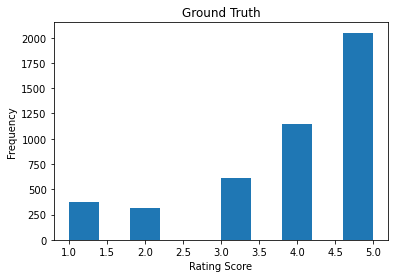

In [70]:
getHistogram('ratingScore', 'Ground Truth')

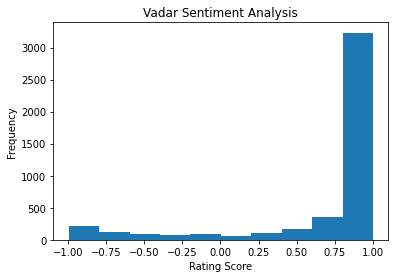

In [71]:
getHistogram('vader', 'Vadar Sentiment Analysis')

**Ans 5(a) (a):**

Both the histograms with ground truth and vader sentiment score depict a similar trend. The ground truth rating (4/5) had a vader score of 1. It shows that there are high number of reviews which have high avg.score, i.e., higher number of positive reviews.

###(b)

In [72]:
review_count = (data.groupby('hotelName')['reviewColumn'].count()).reset_index()
review_count

,hotelName,reviewColumn
0,Admiral Inn Hamilton,129
1,Airport Inn,130
2,Best Western Plus Burlington Inn &amp; Suites,228
3,Best Western Premier C Hotel By Carmen&#39;s,492
4,Breakfast at Tifferet&#39;s,2
5,Canadas Best Value Inn-Burlington/Hamilton,30
6,Comfort Inn,110
7,Comfort Inn Hamilton,75
8,Convenient &amp; Comfortable Manor,1
9,"Courtyard by Marriott Hamilton,",162


In [73]:
review_count.describe()

,reviewColumn
count,39.000000
mean,115.230769
std,137.627159
min,1.000000
25%,11.500000
50%,38.000000
75%,161.000000
max,492.000000


Text(0, 0.5, 'No of Hotels')

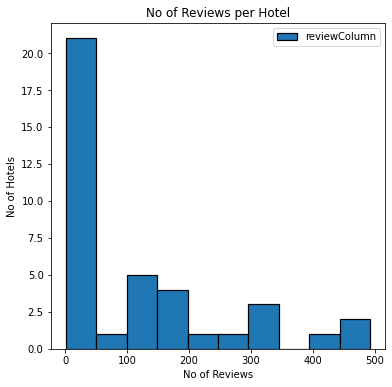

In [74]:
review_count.plot(kind='hist',figsize=(6,6),edgecolor='black', linewidth=1.2)
plt.title('No of Reviews per Hotel')
plt.xlabel('No of Reviews')
plt.ylabel('No of Hotels')

**Ans 5(a) (b):**

The maximum number of reviews for a hotel were 492. Out of the 39 hotels, majority of the hotels had less than 125 reviews.

###(b): Boxplots

###(a)

Ground Truth rated hotels

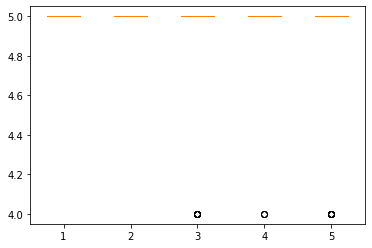

In [75]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

Log_Inn = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
The_Homestead_1867_BB = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
Serenity_Ranch_BB = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
OslerHouse = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
The_Barracks_Inn = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data_box1= [Log_Inn, The_Homestead_1867_BB, Serenity_Ranch_BB, OslerHouse, The_Barracks_Inn]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_box1)
plt.show()

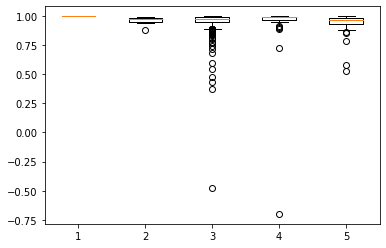

In [76]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel_1 = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel_1['hotelName'].values

Log_Inn = finaldf.loc[finaldf['hotelName'] == tp5gthotel_1['hotelName'].values[0]]['vader']
The_Homestead_1867_BB = finaldf.loc[finaldf['hotelName'] == tp5gthotel_1['hotelName'].values[1]]['vader']
Serenity_Ranch_BB = finaldf.loc[finaldf['hotelName'] == tp5gthotel_1['hotelName'].values[2]]['vader']
OslerHouse = finaldf.loc[finaldf['hotelName'] == tp5gthotel_1['hotelName'].values[3]]['vader']
The_Barracks_Inn = finaldf.loc[finaldf['hotelName'] == tp5gthotel_1['hotelName'].values[4]]['vader']

data_box2= [Log_Inn, The_Homestead_1867_BB, Serenity_Ranch_BB, OslerHouse, The_Barracks_Inn]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_box2)
plt.show()

Vader rated hotels

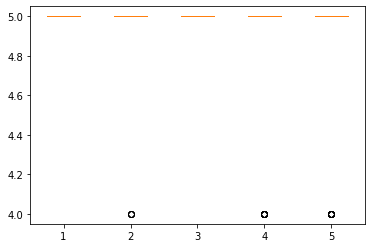

In [77]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5vdhotel = hotelRatingDfVd.sort_values('avgRatingScore',ascending=0).head(5)
tp5vdhotel['hotelName'].values

Log_Inn = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[0]]['ratingScore']
Ridgemoor_BB = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[1]]['ratingScore']
The_Homestead_1867_BB = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[2]]['ratingScore']
Serenity_Ranch_BB = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[3]]['ratingScore']
The_Barracks_Inn = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[4]]['ratingScore']

data_box3= [Log_Inn, Ridgemoor_BB, The_Homestead_1867_BB, Serenity_Ranch_BB, The_Barracks_Inn]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_box3)
plt.show()

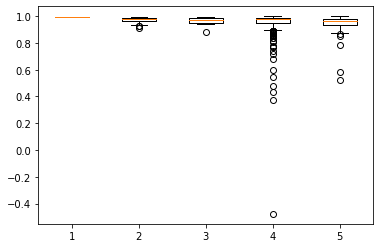

In [78]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5vdhotel_1 = hotelRatingDfVd.sort_values('avgRatingScore',ascending=0).head(5)
tp5vdhotel_1['hotelName'].values

Log_Inn = finaldf.loc[finaldf['hotelName'] == tp5vdhotel_1['hotelName'].values[0]]['vader']
Ridgemoor_BB = finaldf.loc[finaldf['hotelName'] == tp5vdhotel_1['hotelName'].values[1]]['vader']
The_Homestead_1867_BB = finaldf.loc[finaldf['hotelName'] == tp5vdhotel_1['hotelName'].values[2]]['vader']
Serenity_Ranch_BB = finaldf.loc[finaldf['hotelName'] == tp5vdhotel_1['hotelName'].values[3]]['vader']
The_Barracks_Inn = finaldf.loc[finaldf['hotelName'] == tp5vdhotel_1['hotelName'].values[4]]['vader']

data_box4= [Log_Inn, Ridgemoor_BB, The_Homestead_1867_BB, Serenity_Ranch_BB, The_Barracks_Inn]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_box4)
plt.show()

###(b)

Rating Score

In [79]:
top5df=finaldf.loc[finaldf['hotelName'].isin(tp5gthotel['hotelName'].values)]
mean_RS=top5df.groupby('hotelName')['ratingScore'].mean().to_frame(name='mean').reset_index()
var_RS=top5df.groupby('hotelName')['ratingScore'].var().to_frame(name='variance').reset_index().fillna(0)
meanvardf=mean_RS.merge(var_RS, on='hotelName')
meanvardf

,hotelName,mean,variance
0,Log Inn,5.000000,0.000000
1,Osler House,4.938776,0.058673
2,Serenity Ranch Bed and Breakfast,4.976471,0.023044
3,The Barracks Inn,4.921569,0.072996
4,The Homestead 1867 Bed &amp; Breakfast,5.000000,0.000000


Vader Score

In [80]:
top5df=finaldf.loc[finaldf['hotelName'].isin(tp5gthotel['hotelName'].values)]
mean_VD=top5df.groupby('hotelName')['vader'].mean().to_frame(name='mean').reset_index()
var_VD=top5df.groupby('hotelName')['vader'].var().to_frame(name='variance').reset_index().fillna(0)
meanvardf=mean_VD.merge(var_VD, on='hotelName')
meanvardf

,hotelName,mean,variance
0,Log Inn,0.997100,0.000000
1,Osler House,0.937584,0.058983
2,Serenity Ranch Bed and Breakfast,0.949677,0.011466
3,The Barracks Inn,0.947759,0.004512
4,The Homestead 1867 Bed &amp; Breakfast,0.960514,0.001605


###(c)

**Ans 5(b) (c):**

On analyzing the plots and mean values, I find both the information quite valuable. Since the data was skewed, it was difficult interpreting the actual values of mean, median and the quartile values from the box plot. One thing the box plots can do better is depicting the outliers in the data which is not generally descriptive in mean, variance values. Removal of these outliers will certainly have a effect on the final mean and variance values.


###(c): Scatterplots and heatmaps

###(a)

Text(0.5, 0, 'Vader Score')

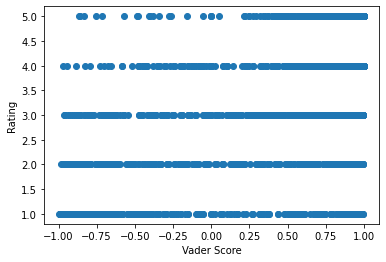

In [81]:
y = finaldf['ratingScore'].values
x = finaldf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [0]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Rating')

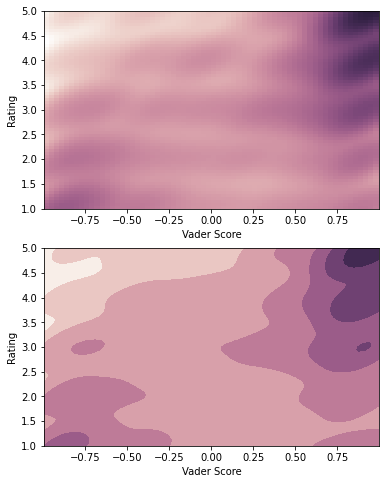

In [83]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

**Ans 5(c) (a):**

Scatterplots closely show the relation between the vader sentiment and the ratings. It was observed that most of the ratings with a score of 5 were rated 1 on the vader scale and ratings with score 1 were rated -1 on the vader scale. This shows how closely vader sentiment resembles the true human ranking system. Furthermore, this conclusion is verified by the heatmap which shows the concentration of ratings and the vader score. Stronger the relation, denser is the color.


###(b)

Text(0.5, 0, 'Review Length')

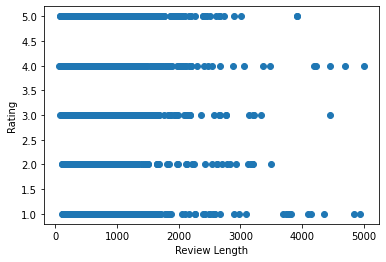

In [84]:
y = finaldf['ratingScore'].values
x = finaldf['reviewCol'].map(len).values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Review Length')

Text(0, 0.5, 'Rating')

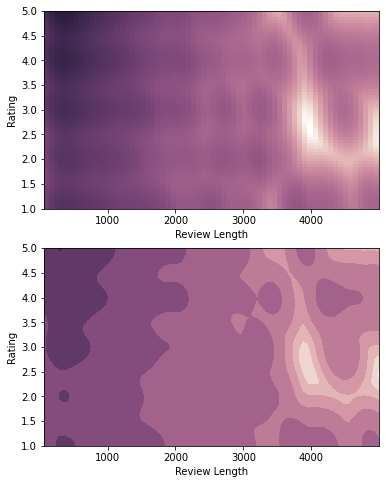

In [85]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Review Length')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Review Length')
ax2.set_ylabel('Rating')

Text(0.5, 0, 'Length')

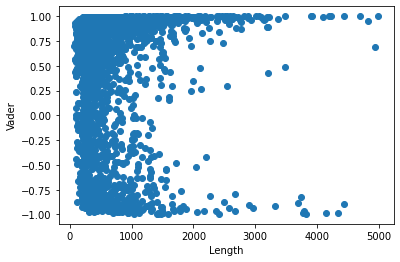

In [86]:
y = finaldf['vader'].values
x = finaldf['reviewCol'].map(len).values
plt.plot(x, y,"o")
plt.ylabel('Vader')
plt.xlabel('Length')

Text(0, 0.5, 'Vader')

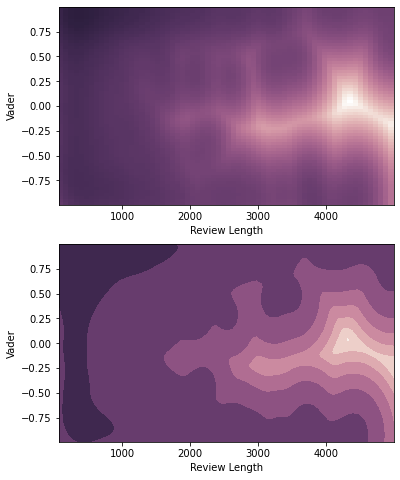

In [87]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Review Length')
ax1.set_ylabel('Vader')

ax2.set_xlabel('Review Length')
ax2.set_ylabel('Vader')

**Ans 5(c) (b):**

From the scatterplots and the heatmap, there wasn't any visible connection between the length of review and the score. Majority of the reviews were around 2300 characters. However, reviews with a higher length were predominatly rated higer on the vader scale as well as on the rating score.

###(c)

In [0]:
gtmerge = review_count.merge(hotelRatingDfGt, on = 'hotelName')
vdmerge = gtmerge.merge(hotelRatingDfVd, on = 'hotelName')
vdmerge.rename(columns = {'avgRatingScore_x':'avgRatingScore', 'avgRatingScore_y':'avgVaderScore', 'reviewColumn':'NoofReviews'}, inplace = True)

Text(0.5, 0, 'No of Reviews')

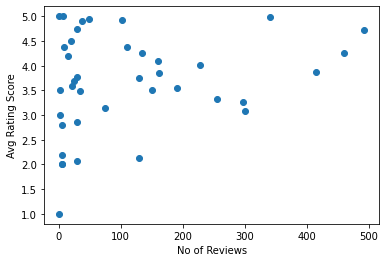

In [89]:
y = vdmerge['avgRatingScore'].values
x = vdmerge['NoofReviews'].values
plt.plot(x, y,"o")
plt.ylabel('Avg Rating Score')
plt.xlabel('No of Reviews')

Text(0.5, 0, 'No of Reviews')

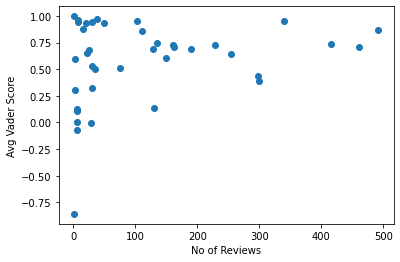

In [90]:
y = vdmerge['avgVaderScore'].values
x = vdmerge['NoofReviews'].values
plt.plot(x, y,"o")
plt.ylabel('Avg Vader Score')
plt.xlabel('No of Reviews')

**Ans 5(c) (c):**

Both the scatter plots show similar trends but there is no deduecible trend from the plots. There were 4 hotels with reviews above 400 all of which had very high scores in both measures which shows their popularity and tells us that those hotels had the most number of positive reviews.